In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [25]:
from fastai.vision import *
from fastai.metrics import accuracy
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
path = untar_data(URLs.MNIST_SAMPLE)

In [5]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

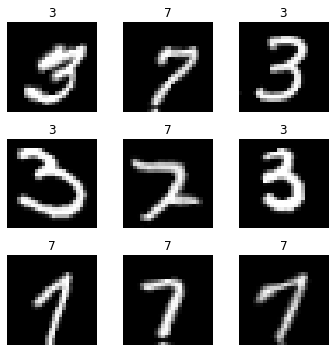

In [6]:
data.show_batch(rows=3, figsize=(5,5))

In [7]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.199768,0.091580,0.972522,00:07
1,0.120796,0.065498,0.977920,00:05


In [60]:
class FGSM(LearnerCallback):
    def __init__(self):
        super().__init__(learn)
        self.model = learn.model
        
    def on_batch_begin(self, **kwargs):
        X = kwargs['last_input'].clone()
        y = kwargs['last_target']
        if not kwargs['train']:       
            X = self.fgsm(X, y)
            return {'last_input': X}
    
    def fgsm(self, X, y, epsilon=64/255):
        x = X.clone().detach()
        x = to_device(x, device)
        y = to_device(y, device)
        x = x.requires_grad_(True)
        with torch.enable_grad():
            out = self.model(x)
            losses = nn.CrossEntropyLoss(reduction='none')(out, y)
            loss = torch.mean(losses)
            grad, = torch.autograd.grad(loss, [x])
        x = x + torch.sign(grad) * epsilon
        x = torch.clamp(x, 0, 1)
        return x

In [63]:
learn.validate(data.valid_dl, callbacks=[FGSM()]) # under attack

[6.209123, tensor(0.5044)]

In [64]:
learn.validate(data.valid_dl) # not under attack

[0.065498285, tensor(0.9779)]

In [51]:
x, y = data.one_batch()

In [61]:
x_adv = FGSM().fgsm(x, y)

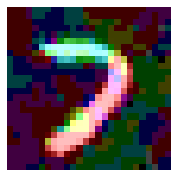

In [62]:
show_image(x_adv[0]) # adversarial example